In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import holidays
from datetime import date


In [24]:
df = pd.read_csv("https://datalaketech4.blob.core.windows.net/dados-ipea/cotacao_petroleo_ipea.csv", encoding="ISO-8859-1", delimiter=";", decimal=",")

In [25]:
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
df = df.set_index("data")

In [33]:
br_feriados = holidays.Brazil(years=range(2015, 2026))

feriados_dict = {}
for data, nome in br_feriados.items():
    if data <= date(2025, 4, 30):
        feriados_dict.setdefault(nome, []).append(str(data))

dfs_feriados = []
for nome, datas in feriados_dict.items():
    df_feriados = pd.DataFrame({
        'holiday': nome.lower().replace(" ", "_"),
        'ds': pd.to_datetime(datas),
        'lower_window': 0,
        'upper_window': 1
    })
    dfs_feriados.append(df_feriados)

feriados = pd.concat(dfs_feriados, ignore_index=True)

In [27]:
df = df.asfreq('D')

In [65]:
tamanho_treino = int(len(df) * 0.9)

In [66]:
df_prophet = df.reset_index()
df_prophet.columns = ['ds', 'y']
treino_prophet = df_prophet.iloc[:tamanho_treino]
teste_prophet = df_prophet.iloc[tamanho_treino:]

In [67]:
modelo_prophet = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0,
    holidays=feriados
)
modelo_prophet.fit(treino_prophet)

12:22:12 - cmdstanpy - INFO - Chain [1] start processing
12:22:13 - cmdstanpy - INFO - Chain [1] done processing


In [75]:
ultima_data_teste = teste_prophet['ds'].max()
dias_teste = (ultima_data_teste - treino_prophet['ds'].max()).days
periodos = dias_teste + 60


In [77]:
futuro = modelo_prophet.make_future_dataframe(periods=periodos, freq='D')
predicoes_prophet = modelo_prophet.predict(futuro)
predicoes_prophet = predicoes_prophet.set_index('ds')
predicoes_prophet = predicoes_prophet['yhat']
#predicoes_prophet = predicoes_prophet.reindex(teste_prophet['ds'])
predicoes_prophet

ds
2015-01-01    56.544224
2015-01-02    54.688221
2015-01-03    52.300156
2015-01-04    52.816652
2015-01-05    52.917869
                ...    
2025-06-23    68.473811
2025-06-24    68.272897
2025-06-25    68.118057
2025-06-26    67.976628
2025-06-27    67.996754
Name: yhat, Length: 3831, dtype: float64

In [88]:
predicoes_prophet60 = predicoes_prophet.iloc[-60:]

In [105]:
predicoes_prophet60 = pd.DataFrame(predicoes_prophet60)

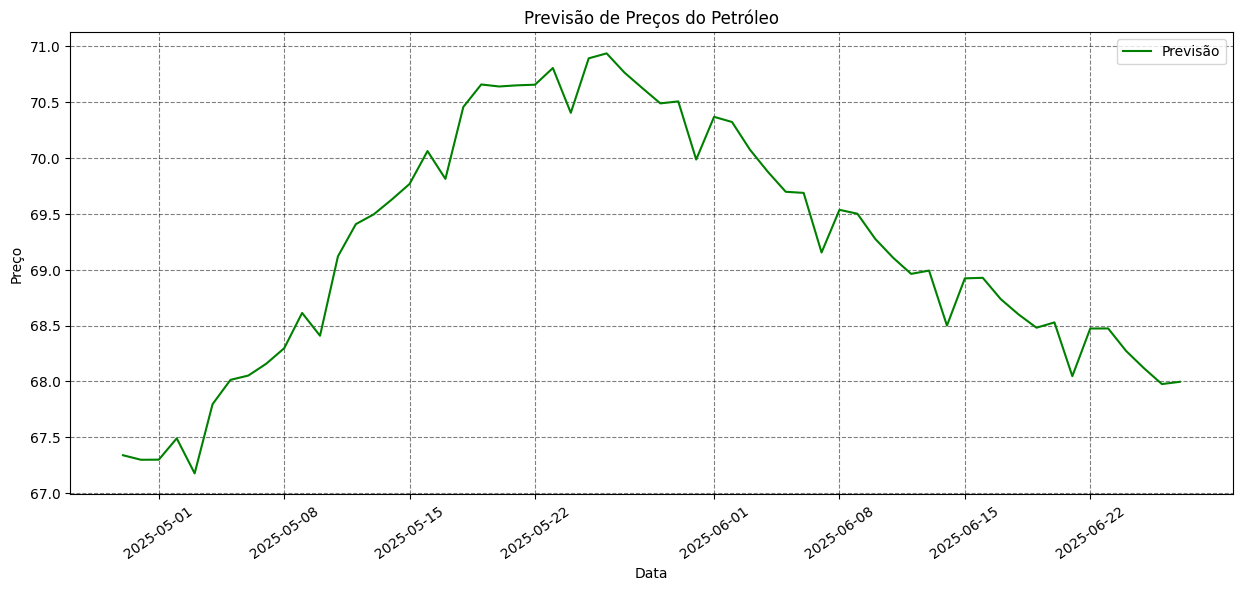

In [104]:
plt.figure(figsize=(15, 6))
plt.plot(predicoes_prophet60.index, predicoes_prophet60, label='Previsão', color='green')
plt.title('Previsão de Preços do Petróleo')
plt.xticks(rotation=35)
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(linestyle='--', alpha=0.5, color='black')
plt.show()